In [34]:
module FastSlamWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: IdealAgent, Agent, EstimationAgent, TrueLandmark, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: Estimator, Particle, set_ml, motion_update, observation_update, resampling_system

mutable struct EstimatedLandmark <: Landmark
    pos::Array{Float64}
    id::Int64
    cov::Matrix{Float64}
    EstimatedLandmark(pos=[0, 0], id=-1, cov=[1 0;0 2]) = new(pos, id, cov)
end

function sigma_ellipse(p, cov, n)
    eig_vals, eig_vec = eigen(cov)
    ang_rad = atan(eig_vec[:, 1][2], eig_vec[:,1][1])
                
    width = n*(eig_vals[1])^(1/2)
    height = n*(eig_vals[2])^(1/2)
    
    theta = LinRange(0, 2pi, 500)
    x = width * sin.(theta)
    y = height * cos.(theta)
    
    #R = [cos(angle_rad) -sin(angle_rad); sin(angle_rad) cos(angle_rad)]
    x_rotate = cos(ang_rad) .* x - sin(ang_rad) .* y
    y_rotate = sin(ang_rad) .* x + cos(ang_rad) .* y    
    
    return p[1] .+ x_rotate, p[2] .+ y_rotate
end

function draw(self::EstimatedLandmark, plt)

    # 推定位置に青い星を描く
    plot!(plt, [self.pos[1]], [self.pos[2]], c=:blue, markershape=:star5, label="")

    # 誤差楕円を描く
    ex, ey = sigma_ellipse(self.pos, self.cov, 3)
    plot!(plt, ex, ey, c=:blue, label="")

end

mutable struct StateAndMapParticle <: Particle
    pose::Array{Float64}
    weight::Float64
    landmark_num::Int64
    map::Map

    function StateAndMapParticle(
        pose,
        weight,
        landmark_num;
        map=Map())

        for i in 1:landmark_num
            append(map, EstimatedLandmark())
        end
    
        new(
            pose,
            weight,
            landmark_num,
            map
        )
    end

end

mutable struct FastSlam <: Estimator
    init_pose::Array{Float64}
    particle_num::Int64
    landmark_num::Int64
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}
    alphas::Dict

    function FastSlam(
        init_pose,
        particle_num,
        landmark_num;
        map=Map(),
        particles=[StateAndMapParticle(init_pose, 1.0/particle_num, landmark_num) for i in 1:particle_num],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose,
        alphas=Dict()
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            particle_num,
            landmark_num,
            map,
            particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose,
            alphas
        )
    end

end

function draw(self::FastSlam, plt)

    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    scale=0.5
    quiver!(plt, xs, ys, quiver=(scale*vxs, scale*vys), c=:orange)

    draw(self.ml.map, plt)
    
end

end

Main.FastSlamWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_fastslam/tmp.gif")
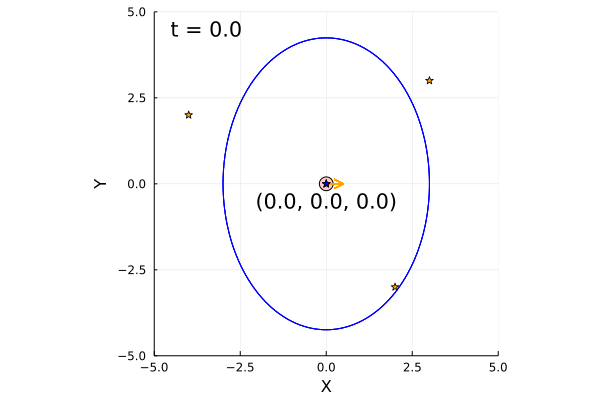

In [35]:
using .FastSlamWorld
using Distributions

function trial(animation=true)

    time_interval = 0.1    
    world = FastSlamWorld.World(30, 0.1)

    ### 地図を生成して2つランドマークを追加 ###
    m = FastSlamWorld.Map()
    FastSlamWorld.append(m, FastSlamWorld.TrueLandmark([-4, 2]))
    FastSlamWorld.append(m, FastSlamWorld.TrueLandmark([2, -3]))
    FastSlamWorld.append(m, FastSlamWorld.TrueLandmark([3, 3]))
    FastSlamWorld.append(world, m)

    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlamWorld.FastSlam(initial_pose, 100, length(m.landmarks), map=m)
    a = FastSlamWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
    r = FastSlamWorld.RealRobot(initial_pose, :red, 0.2, a, sensor=FastSlamWorld.RealCamera(m))
    FastSlamWorld.append(world, r)

    if animation
        FastSlamWorld.draw(world)
    else
        FastSlamWorld.draw(world)
        return pf
    end
end

pf =trial()